# Environment setup

In [1]:
from scipy.io import loadmat
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

# Path to musicImagery dataset
dataDir = r'data/musicImagery/'
#dataDir = r'D:\marion_music_imagery\datasetCND_musicImagery\musicImagery'

In [2]:
%matplotlib widget

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

// This disables scrolling outputs

<IPython.core.display.Javascript object>

# Load stimuli
Note: ```stimIndxs``` range from 1 to 4 and ```condIdxs``` range from 1-2.
These are _not_ 0-indexed.

In [4]:
stim_mat = loadmat(dataDir+r"/dataCND/dataStim.mat", simplify_cells = True) 
stim = stim_mat['stim']
# print(stim)

stimIdxs = stim['stimIdxs']
print(f'stimIdxs shape (N trials): {stimIdxs.shape}')

condIdxs = stim['condIdxs']
print(f'condIdxs shape (N trials): {condIdxs.shape}')

condNames = stim['condNames']
print(f'condNames shape (P conditions): {condNames.shape}')

stim_events = stim['data']
print(f'events shape (M features, N trials): {stim_events.shape}')

stim_event_labels = stim['names']
print(f'event names shape (M features): {stim_event_labels.shape}')

fs_stim = stim['fs'] # ignore, use fs from data struct (64 Hz)
print(f'fs: {fs_stim} Hz')

stimIdxs shape (N trials): (88,)
condIdxs shape (N trials): (88,)
condNames shape (P conditions): (2,)
events shape (M features, N trials): (2, 88)
event names shape (M features): (2,)
fs: 64 Hz


In [5]:
# Handy mapping of indices to labels
stimId_to_Song_map = {
    2: 'chor-038', 
    1: 'chor-096', 
    3: 'chor-101',
    4: 'chor-019', 
} # from read_stim_midi.ipynb

stimLabel_to_id_map = {
    'chor-038': 2, 
    'chor-096': 1, 
    'chor-101': 3,
    'chor-019': 4, 
} # reverse mapping

stimLabel_to_sheet_order_map = {
    'chor-038': 1, 
    'chor-096': 2, 
    'chor-101': 3,
    'chor-019': 4, 
} # order of songs on sheet music

condId_to_State_map = {
    1: 'Listening', 
    2: 'Imagery'
} # from condNames

# Stim Channel

Finding tactile metronome onsets

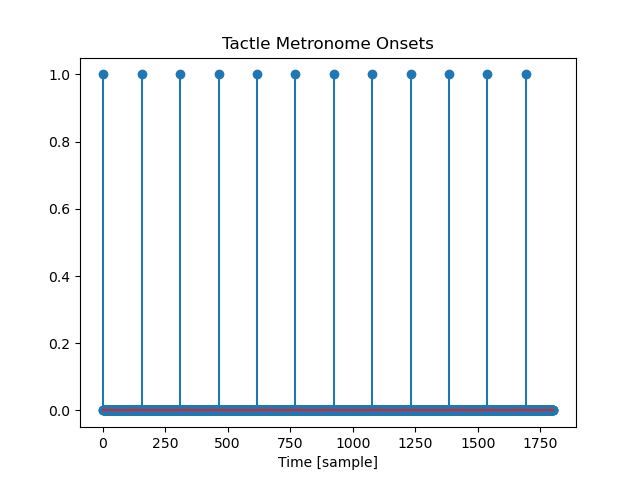

In [6]:
# From Guilhem's note
barOnsets = [1, 157] # in sample indices

cueTime = 310 # third bar
for barIdx in range(10): # 12 bars total
    barOnsets.append(cueTime)
    if barIdx%2 == 1:
        cueTime += 153
    else:
        cueTime += 154
        
cueTime -= 1 # index from 0

# Make a new exp vector for metronome hits
cueExp = np.zeros_like(stim_events[1][0]) # same size as the first expectation vector
cueExp[barOnsets] = 1

plt.figure()
plt.stem(cueExp, '*')
plt.xlabel('Time [sample]')
plt.title('Tactle Metronome Onsets')
plt.show()

Note onsets for stim channel

In [7]:
stim = {}
for stimLabel in [
    'chor-038', 
    'chor-096', 
    'chor-101',
    'chor-019']: # top to bottom on the sheet music

    stim[stimLabel] = {}
    
    # Collect note and beat onsets for current stim
    stimIdx = stimLabel_to_id_map[stimLabel]
    stimExp = stim_events[1][11*(stimIdx-1)] # expectations vector for current stim
    note_onsets = stimExp > 0
    stim[stimLabel]['notes'] = note_onsets
    stim[stimLabel]['beats'] = cueExp

These indices will be used later to identify song and condition for a given subject's trial order:

In [8]:
# Collect stim idxs by condition and song
idxs = {} # dict to store idxs for each condition and stim/song idx

for condIdx in np.unique(condIdxs): # two conditions
    condName = condNames[condIdx-1] # MATLAB indexes from 1...
    idxs[condName] = {}
    
    for stimIdx in np.unique(stimIdxs):
        
        stimName = stimId_to_Song_map[stimIdx]
        
        print(f'{condName}: Song {stimName}: Indices:') 
        matched_ndx = np.where(
            (stimIdxs == stimIdx) & (condIdxs == condIdx)
            )[0]
        print(matched_ndx)
        
        idxs[condName][stimName] = matched_ndx

Listening: Song chor-096: Indices:
[ 0  1  2  3  4  5  6  7  8  9 10]
Listening: Song chor-038: Indices:
[11 12 13 14 15 16 17 18 19 20 21]
Listening: Song chor-101: Indices:
[22 23 24 25 26 27 28 29 30 31 32]
Listening: Song chor-019: Indices:
[33 34 35 36 37 38 39 40 41 42 43]
Imagery: Song chor-096: Indices:
[44 45 46 47 48 49 50 51 52 53 54]
Imagery: Song chor-038: Indices:
[55 56 57 58 59 60 61 62 63 64 65]
Imagery: Song chor-101: Indices:
[66 67 68 69 70 71 72 73 74 75 76]
Imagery: Song chor-019: Indices:
[77 78 79 80 81 82 83 84 85 86 87]


# Load EEG data for a subject

Make a list of raws for each subject, in original trial order

Steps needed:
- Make an MNE info object
    - Add trial condition and song name to raw's description
- Correct channel names for applying biosemi64 montage
- Add a stim channel with note and beat onsets 
    - Note, there are no overlapping events as any notes overlapped with beat onsets are removed from the stim mat files (these can still be recovered from the MIDI if needed)

In [9]:
def all_raws_for_subject(
        subjectID = 1,
        BEAT_EVENT_MARKER = 1,
        NOTE_EVENT_MARKER = 128,
    ):
    
    # Path to data for selected subject
    sub1_mat = loadmat(dataDir+f"/dataCND/dataSub{subjectID}.mat", simplify_cells = True) 

    # This should be the same as fs_stim above
    fs = sub1_mat['eeg']['fs']

    # EEG dataset for selected subject
    data = sub1_mat['eeg']['data']

    # Randomized trial order for current subject
    orig_trial_pos = sub1_mat['eeg']['origTrialPosition']
    print(f'orig_trial_pos: {orig_trial_pos}')

    # Get current subject's song and condition ordering (since its randomized)
    thisSubStimOrder = stimIdxs[(orig_trial_pos-1)] # convert to being zero indexed
    thisSubCondOrder = condIdxs[(orig_trial_pos-1)]

    # EEG channel map
    chanLocs = sub1_mat['eeg']['chanlocs']
    montage_chs = [] # get channel names and order from chanLocs
    for k in chanLocs:
        ch_n = k['labels'].split(' (')[0] # remove paranthesis from name
        montage_chs.append(ch_n)

    # Make an info object
    info = mne.create_info(
            ch_names=montage_chs + ['midi'], 
            sfreq=fs, 
            ch_types=['eeg']*len(chanLocs) + ['stim']
        )
    info.set_montage('biosemi64', match_case=False) # resolves Afz case trouble

    raw_trials = []
    for trialIdx in orig_trial_pos-1: # go back to original trial order

        # What stim and condition (state) is this trial?
        stimIdx = thisSubStimOrder[trialIdx]
        condIdx = thisSubCondOrder[trialIdx]

        info['description'] = str(trialIdx) #f'{condId_to_State_map[condIdx]}/{stimId_to_Song_map[stimIdx]}'
        
        stimLabel = stimId_to_Song_map[stimIdx]
        stim_data = NOTE_EVENT_MARKER * stim[stimLabel]['notes'] + BEAT_EVENT_MARKER * stim[stimLabel]['beats']
        print(stim_data.shape)
        print(data[trialIdx].shape)

        # Rescale data to Volts, Add the stim channel
        eeg_and_stim_data = np.vstack((data[trialIdx].T / 1e6, stim_data))
        
        raw = mne.io.RawArray(
            data = eeg_and_stim_data, # transpose for importing to MNE
            info = info,
        )

        raw_trials.append(raw)

    return raw_trials

def merged_raws_for_subject(subjectID):
    
    # Collect a list of raws per subject
    raw_trials = all_raws_for_subject(subjectID = subjectID)
    print(len(raw_trials))

    # Now concatenate these raws
    for raw in raw_trials:
        trialIdx = int(raw.info['description'])
        stimLabel = stimId_to_Song_map[stimIdxs[trialIdx]]
        condLabel = condId_to_State_map[condIdxs[trialIdx]]
        print(f"sub{subjectID}\ttrial #{raw.info['description']}\t{condLabel}\t{stimLabel}")

        # https://mne.tools/stable/auto_tutorials/raw/30_annotate_raw.html
        trial_annot = mne.Annotations(
            onset = [0],
            duration = raw[0][-1][-1], # entire duration of the trial
            description = f'{condLabel}/{stimLabel}'
        )

        raw.set_annotations(trial_annot)

    return mne.concatenate_raws(raw_trials)

List of raws, in original trial order, by subject

In [10]:
from collections import OrderedDict

Only run this cell once after the cell above?

In [11]:
# Collect merged raws per subject
merged_raw_trials = OrderedDict()

for subjectID in [1, 3, 7, 11]:
    merged_raw_trials[subjectID] = merged_raws_for_subject(subjectID)

orig_trial_pos: [ 3  9 15 16 27 28 30 37 48 49 53  4  7 12 29 34 35 38 52 59 63 71  8 11
 22 24 31 36 39 40 67 75 87 13 18 25 45 46 50 55 56 57 65 77 19 20 32 33
 42 58 62 70 80 85 88  2 26 43 44 47 60 61 68 69 74 86  1 14 17 23 41 64
 72 76 78 79 84  5  6 10 21 51 54 66 73 81 82 83]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

Using matplotlib as 2D backend.


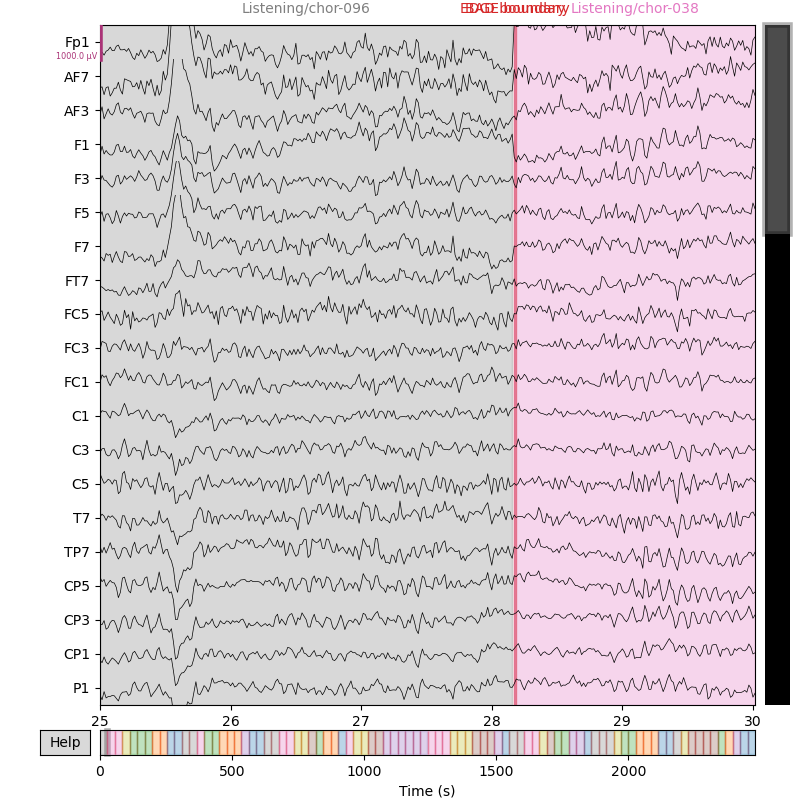

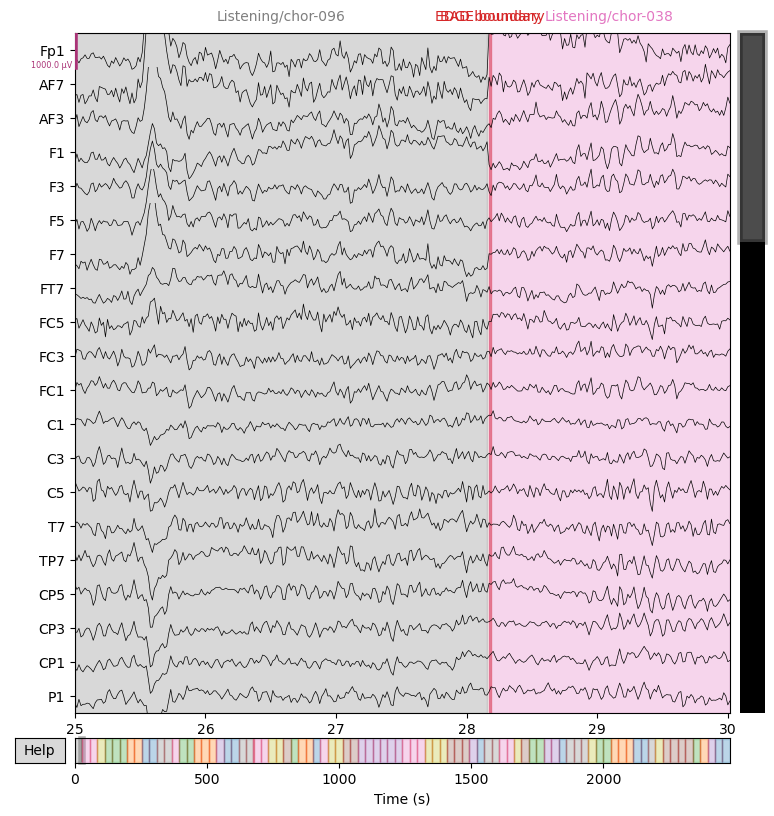

In [12]:
merged_raw_trials[subjectID].plot(
    duration = 5,
    start = 25,
    scalings = {'eeg': 500e-6}
)

In [13]:
merged_raw_trials[subjectID]

<RawArray | 65 x 158664 (2479.1 s), ~78.8 MB, data loaded>

# Plot ICs for 11 trials for same condition / song / subject

In [14]:
def get_eps_idx_matching_condition(eps, condition):
    
    trial_order = []
    for i in range(88):
        ep = eps[i]
        this_ep_event_id = eps[i].event_id
        #print(this_ep_event_id)
        
        if condition in this_ep_event_id.keys():
            trial_order.append(i)
    
    return trial_order

Used Annotations descriptions: ['Imagery/chor-019', 'Imagery/chor-038', 'Imagery/chor-096', 'Imagery/chor-101', 'Listening/chor-019', 'Listening/chor-038', 'Listening/chor-096', 'Listening/chor-101']
{'Imagery/chor-019': 1, 'Imagery/chor-038': 2, 'Imagery/chor-096': 3, 'Imagery/chor-101': 4, 'Listening/chor-019': 5, 'Listening/chor-038': 6, 'Listening/chor-096': 7, 'Listening/chor-101': 8}
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  88 events (good & bad), 0 - 28 sec, baseline off, ~91 kB, data not loaded,
 'Imagery/chor-019': 11
 'Imagery/chor-038': 11
 'Imagery/chor-096': 11
 'Imagery/chor-101': 11
 'Listening/chor-019': 11
 'Listening/chor-038': 11
 'Listening/chor-096': 11
 'Listening/chor-101': 11>
Using data from preloaded Raw for 11 events and 1793 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 11 events and 1793 original time points ...


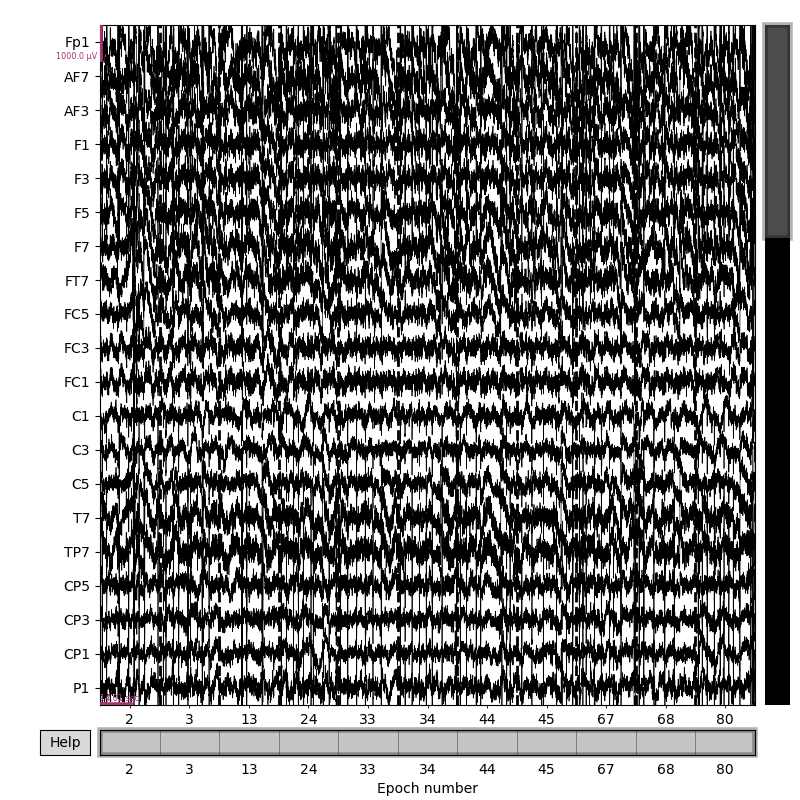

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Using data from preloaded Raw for 11 events and 1793 original time points ...
0 bad epochs dropped
Selecting by number: 63 components


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_38339/1524239854.py:54: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(


Using data from preloaded Raw for 11 events and 1793 original time points ...
Fitting ICA took 4.3s.
Using data from preloaded Raw for 11 events and 1793 original time points ...
0 bad epochs dropped
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


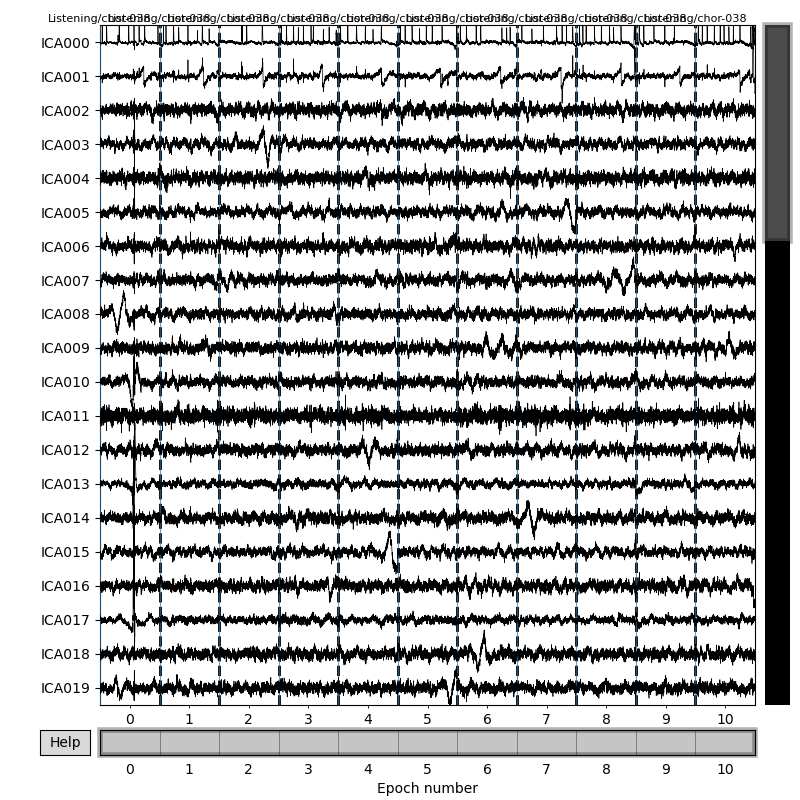

Using data from preloaded Raw for 11 events and 1793 original time points ...
0 bad epochs dropped
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


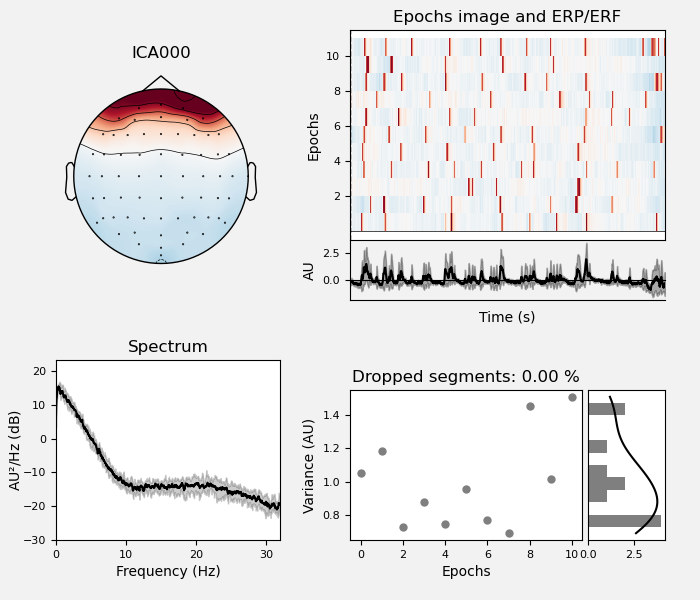

[<Axes: label='topomap', title={'center': 'ICA000'}>, <Axes: label='image', title={'center': 'Epochs image and ERP/ERF'}, ylabel='Epochs'>, <Axes: label='erp', xlabel='Time (s)', ylabel='AU'>, <Axes: label='spectrum', title={'center': 'Spectrum'}, xlabel='Frequency (Hz)', ylabel='$\\mathrm{AU²/Hz}$$\\ \\mathrm{(dB)}$'>, <Axes: label='variance', title={'center': 'Dropped segments: 0.00 %'}, xlabel='Epochs', ylabel='Variance (AU)'>, <Axes: >]
Using data from preloaded Raw for 11 events and 1793 original time points ...
0 bad epochs dropped
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


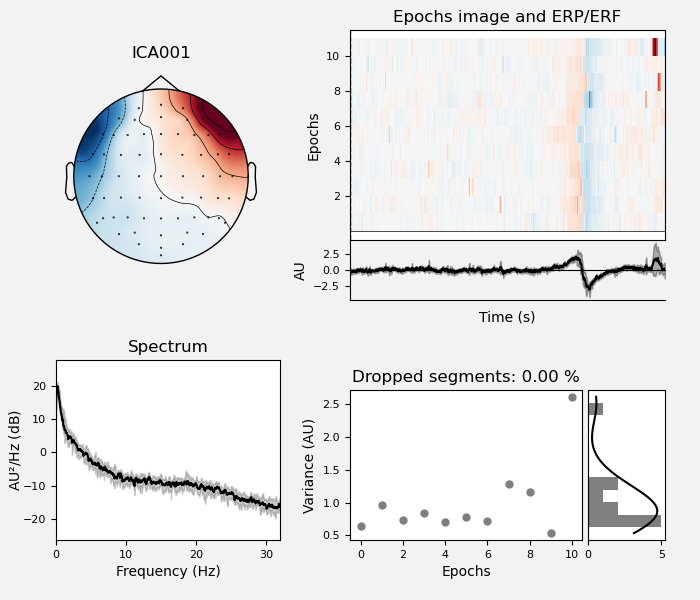

[<Axes: label='topomap', title={'center': 'ICA001'}>, <Axes: label='image', title={'center': 'Epochs image and ERP/ERF'}, ylabel='Epochs'>, <Axes: label='erp', xlabel='Time (s)', ylabel='AU'>, <Axes: label='spectrum', title={'center': 'Spectrum'}, xlabel='Frequency (Hz)', ylabel='$\\mathrm{AU²/Hz}$$\\ \\mathrm{(dB)}$'>, <Axes: label='variance', title={'center': 'Dropped segments: 0.00 %'}, xlabel='Epochs', ylabel='Variance (AU)'>, <Axes: >]


In [15]:
tmin = 0
tmax = 28 # to avoid dropping epochs from major movements towards end of trials
eog_filter = False
common_average = False
condition = 'Listening/chor-038'
SPECTRUM_YLIMS = [-25, 25]
VARIANCE_YLIMS = [0, 3]

for subjectID in [1]:

    raw = merged_raw_trials[subjectID].copy()
    raw.n_times
    raw.tmax

    if eog_filter:
        raw_filt = raw.copy().filter( # ica-label needs 1-100Hz
            l_freq=1, 
            h_freq=10,
        )
        #mne.viz.plot_montage(raw.info.get_montage())
    else:
        raw_filt = raw
        
    if common_average:
        raw_filt.set_eeg_reference('average')

    # Get conditions from events
    events, event_id = mne.events_from_annotations(raw_filt)
    #print(events)
    print(event_id)

    eps = mne.Epochs(
        raw=raw_filt,
        events=events,
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
    )
    print(eps)

    #for condition in ['Listening/chor-038']:

    eps[condition].plot(
        scalings = {'eeg': 500e-6}
    )

    ica = mne.preprocessing.ICA(
        n_components = 63,
        # method='infomax', # needed by ica-label, but takes longer to run than fastica (default)
    )

    # Fit ICA only on epochs matching this one subject and given condition
    ica.fit(
        eps[condition],
        reject = None,
        reject_by_annotation=False,
    )
    #ica_sources = ica.apply(raw_filt)

    # assuming you have a Raw and ICA instance previously fitted
    # label_components(raw_filt, ica, method='iclabel')

    ica.plot_sources(eps[condition])

    for ica_chan in [0, 1]:
        fig = ica.plot_properties(
            eps[condition], #[:-1], # because one epoch got dropped?
            picks = [ica_chan],
            #image_argsdict = {}, # https://mne.tools/stable/generated/mne.viz.plot_epochs_image.html#mne.viz.plot_epochs_image
        )

        print(fig[0].get_axes())
        for ax in fig[0].get_axes():
            if ax.get_label() == 'topomap':
                title_str = f"Subject {subjectID}, {', '.join(condition.split('/'))}\n{ax.get_title()}"
                if ax.get_title() == 'ICA000':
                    title_str += " (Eye Blinks)"
                elif ax.get_title() == 'ICA001':
                    title_str += " (Eye Sweeps)"
                ax.set_title(title_str)

            if ax.get_label() == 'image':
                ax.set_title('Trials (as epochs): image and ERP/ERF')
                ax.set_ylabel('Trial #') # from epochs
                ax.set_xticks([])
                ax.set_xticklabels('') # hide major tick labels
                ax.set_yticks([])
                ax.set_ylim([0, 11])
                ax.set_yticklabels('') # hide major tick labels
                ax.set_yticks(
                    [y + 0.5 for y in range(0, 11)], 
                    minor=True,
                    ) # https://stackoverflow.com/questions/17158382/centering-x-tick-labels-between-tick-marks-in-matplotlib
                ax.set_yticklabels(
                    get_eps_idx_matching_condition(eps, condition), 
                    minor=True,
                )

            if ax.get_label() == 'spectrum':
                ax.set_ylim(SPECTRUM_YLIMS)

            if ax.get_label() == 'erp':
                #ax.get_shared_x_axes().remove(ax) # unlink x-axis from 'image' axis # deprecated?
                ax.set_xticks([tmin, tmax])
                ax.set_xticklabels([None, tmax])
                #ax.set_yticklabels('') # hide major tick labels
            
            if ax.get_label() == 'variance':
                #ax.set_title('Trials (epochs) image and ERP/ERF')
                ax.set_xlabel('Trial #') # from epochs
                ax.set_xticks([])
                ax.set_xticklabels('') # hide major tick labels
                ax.set_xticks(
                    [x for x in range(11)], 
                    #minor=True,
                    ) # https://stackoverflow.com/questions/17158382/centering-x-tick-labels-between-tick-marks-in-matplotlib
                ax.set_xticklabels(
                    get_eps_idx_matching_condition(eps, condition), 
                    #minor=True,
                )
                ax.set_ylim(VARIANCE_YLIMS)

        #fig[0].suptitle(f'Subject {subjectID} {condition}')
        plt.tight_layout()
        if 'Eye Blinks' in title_str:
            fig[0].savefig('ica_eye_blinks.svg', format='svg', dpi=300)
        elif 'Eye Sweeps' in title_str:
            fig[0].savefig('ica_eye_sweeps.svg', format='svg', dpi=300)

#plt.show()

In [16]:
raw

<RawArray | 65 x 158664 (2479.1 s), ~78.8 MB, data loaded>

In [17]:
raw_filt

<RawArray | 65 x 158664 (2479.1 s), ~78.8 MB, data loaded>

Experiment updating axes parameters:

In [18]:
if 0:
    print(fig[0].get_axes())

    for ax in fig[0].get_axes():

        if ax.get_label() == 'topomap':
            ax.set_title(ax.get_title() + ' (Blinks)')

        if ax.get_label() == 'image':
            ax.set_title('Trials (epochs) image and ERP/ERF')
            ax.set_ylabel('Trials') # from epochs
            ax.set_yticks(range(1, 11+1))
            ax.set_yticklabels(range(1, 11+1))
            print(ax.get_shared_x_axes())
            ax.sharex = False
            print(ax._sharex)
            ax._sharex = None
            print(ax._sharex)

        if ax.get_label() == 'erp':
            print(ax._sharex)
            print(dir(ax.get_shared_x_axes()))
            #print(ax.get_shared_x_axes().clean()) # deprecated
            #print(ax.get_shared_x_axes().get_siblings(ax)) # deprecated

        fig[0].suptitle('Subject')

    plt.show()

## EOG events from ICA source

### Run ICA on all epochs (trials) at once, takes ~3 mins per subject 

In [20]:
# from mne_icalabel import label_components

ica_all_trials = mne.preprocessing.ICA(
    n_components = 63,
    # method='infomax', # needed by ica-label, but takes longer to run than fastica (default)
)

# Fit ICA on ALL epochs (trials) for this one subject
ica_all_trials.fit(
    raw, #[condition],
    reject = None,
    reject_by_annotation=False,
)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_38339/3428594453.py:9: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_all_trials.fit(


Selecting by number: 63 components
Fitting ICA took 201.8s.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<ICA | raw data decomposition, method: fastica (fit in 1000 iterations on 158664 samples), 63 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Using data from preloaded Raw for 88 events and 1793 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated


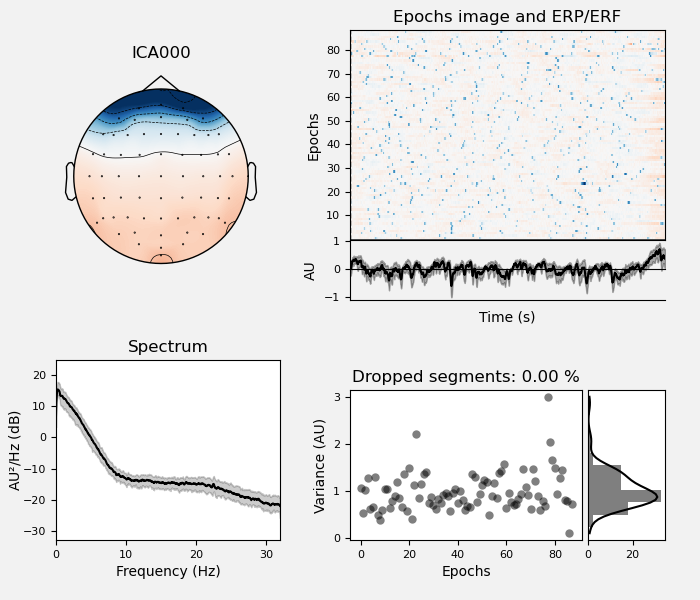

Using data from preloaded Raw for 88 events and 1793 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated


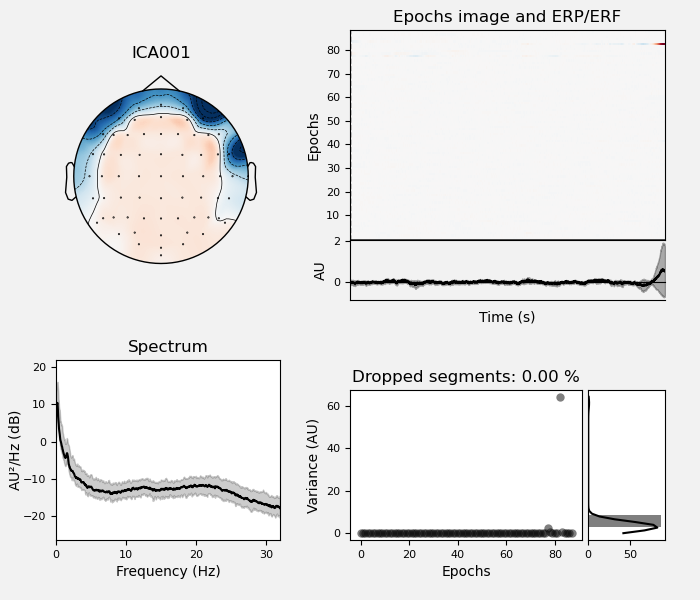

Using data from preloaded Raw for 88 events and 1793 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated


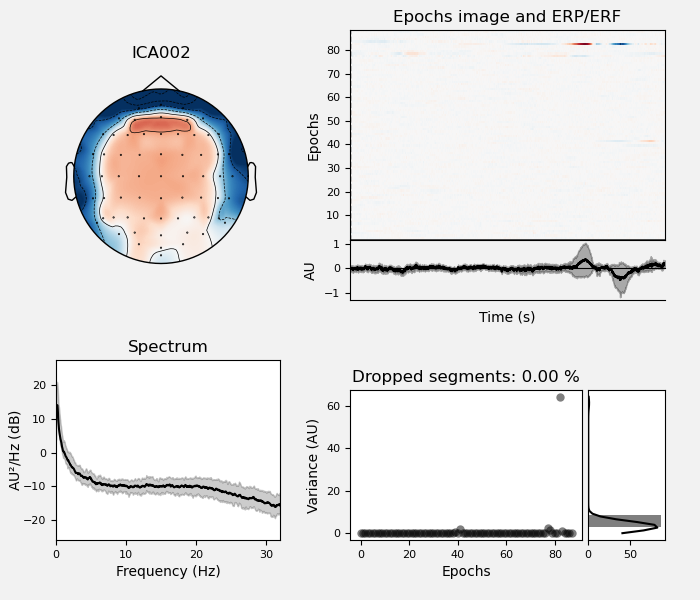

Using data from preloaded Raw for 88 events and 1793 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated


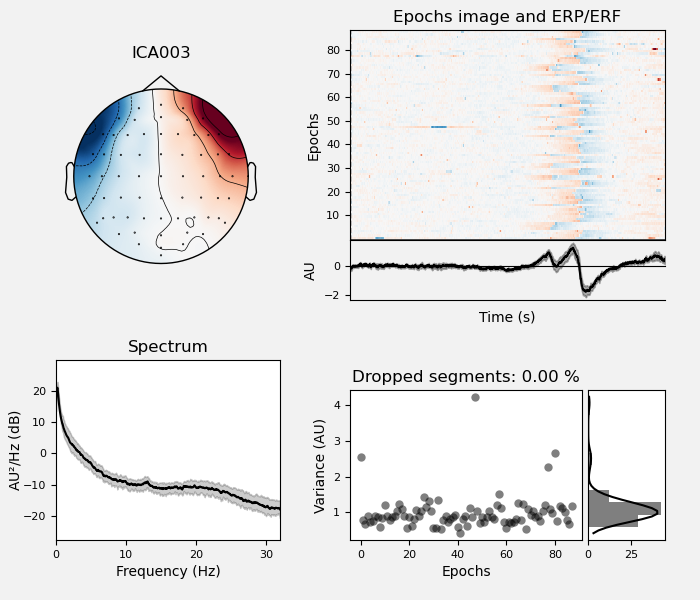

Using data from preloaded Raw for 88 events and 1793 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated


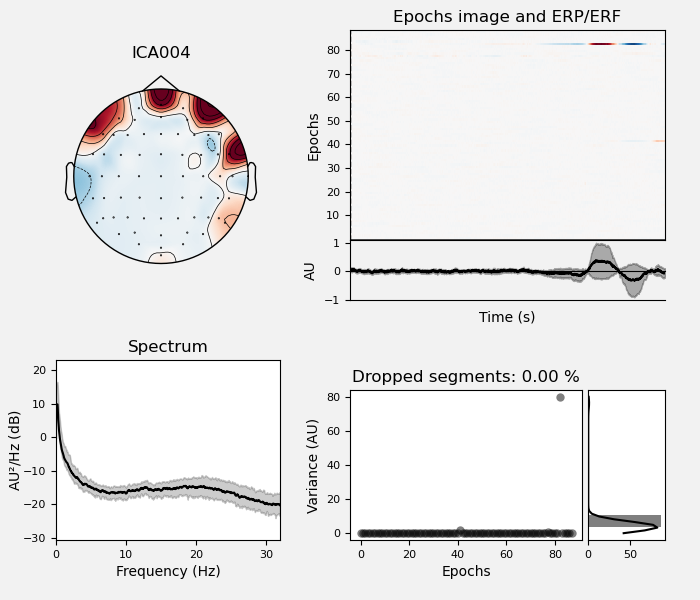

In [24]:
for ica_chan in [0, 1, 2, 3, 4]:
    ica_all_trials.plot_properties(
        eps, # because one epoch got dropped?
        picks = [ica_chan],
        #image_argsdict = {}, # https://mne.tools/stable/generated/mne.viz.plot_epochs_image.html#mne.viz.plot_epochs_image
    )
    plt.show()

Note: eye sweeps form two groups as some chorales had 8 bars and not 9...

# (skip) Reject epochs that could otherwise dominate the ICA plots...


Could just add a reject criterion to ica.fit()?

Instead trying to reject epochs using standard deviation of channel voltage in time domain...

In [22]:
if 0:
    # Flatten the data to get standard deviation
    raw_filt._data[:-1, :].shape # ignore the stim channel
    raw_filt_flat = raw_filt._data[:-1, :].flatten()
    raw_filt_flat.sort()

    std = np.std(raw_filt_flat[:int(.95*len(raw_filt_flat))])
    std = np.std(raw_filt_flat) #[:int(.95*len(raw_filt_flat))])
    print(std)
    plt.hist(raw_filt_flat, bins=1000)

    # Use the standard deviation as rejection criterion (scale a lot to keep eye blinks -- and most epochs)
    eps_rej = mne.Epochs(
        raw=raw_filt,
        events=events,
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject={'eeg': 20*std}, #{'eeg': 15e-3},
        preload = True,
    )
    #print(eps_rej)
    eps_rej.plot_drop_log()

    # Visualize how bad the dropped epochs really are...
    drop_log = eps_rej.drop_log
    bad_epochs_idx = []
    for i in range(len(drop_log)):
        if drop_log[i] != ():
            bad_epochs_idx.append(i)

    for i in range(len(drop_log)):
        if not (i in bad_epochs_idx):
            bad_epochs_idx.append(i) # add a good epoch to the end for comparison
            break

    eps[bad_epochs_idx].plot(
        butterfly=True,
        scalings = {'eeg':10e-3}
    )
    plt.show()

    # See if ICA plotting looks better now...
    for ica_chan in [0, 1, 2, 3]:
        ica.plot_properties(
            eps_rej, # because one epoch got dropped?
            picks = [ica_chan],
            #image_argsdict = {}, # https://mne.tools/stable/generated/mne.viz.plot_epochs_image.html#mne.viz.plot_epochs_image
        )
        plt.show()

# Score similarity between IC and frontal scalp channels

Interestingly this missed the eye sweep component.

In [23]:
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#using-an-eog-channel-to-select-ica-components

# find which ICs match the EOG pattern
eog_indices, eog_scores = ica_all_trials.find_bads_eog(
    #eps_rej,#raw_filt,
    raw,
    # skip filtering again since we are already using 1-10Hz BPF
    l_freq = None, 
    h_freq = None, 
    ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
)

print(eog_indices, eog_scores)

Using EOG channels: Fpz, Fp1, Fp2, AF7, AF3, Afz, AF4, AF8
[0, 1, 4] [array([-7.62307294e-01, -4.21241148e-01, -3.54729947e-01, -7.15766512e-02,
       -5.22363365e-02,  1.45009015e-02,  1.72049567e-01, -1.10775346e-01,
       -3.94170888e-02,  1.07632347e-01, -5.15002942e-02,  2.25824822e-02,
       -9.75412142e-03, -5.94592284e-02, -7.98791598e-03,  5.93248999e-02,
       -7.15456979e-02,  2.83010637e-02,  1.81512407e-02, -9.74210674e-02,
       -5.08417261e-02,  2.61671387e-02,  2.05770439e-02,  4.25085102e-02,
        4.34282969e-02, -3.86555421e-02, -4.56000441e-02,  4.44156100e-02,
       -5.24369690e-03,  3.32792337e-02, -5.23893621e-03,  3.98905397e-02,
        3.04932311e-02,  2.09982241e-02, -2.56728870e-02,  1.02416328e-02,
        1.45539085e-02, -1.24424201e-02, -6.11466009e-02,  1.39006362e-02,
       -2.58404559e-02,  2.14063271e-02,  1.20058054e-02,  3.76663169e-02,
        1.43155899e-02,  8.20175051e-03,  1.82086176e-02,  5.45381090e-03,
       -5.88765133e-04, -4.200

# Manually identify ICA source with blinks / sweeps

In [25]:
BLINK_IC_IDX = 0

In [27]:
raw

<RawArray | 65 x 158664 (2479.1 s), ~78.8 MB, data loaded>

In [29]:
print(raw)

<RawArray | 65 x 158664 (2479.1 s), ~78.8 MB, data loaded>


In [30]:
%matplotlib widget

ica_eog_event_id = 3

eog_filter = False
common_average = False

if eog_filter:
    raw_filt = raw.copy().filter( # ica-label needs 1-100Hz
        l_freq=1, 
        h_freq=10,
    )
    #mne.viz.plot_montage(raw.info.get_montage())
else:
    raw_filt = raw
    
if common_average:
    raw_filt.set_eeg_reference('average')

'''
# Can't use epochs:
ica_eog_events = mne.preprocessing.ica_find_eog_events(
    eps,
    eog_source = eog_src.get_data()[:, BLINK_IC_IDX, :], #eog_src[0][0],
    event_id = ica_eog_event_id,
    #ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
)
'''
print(raw_filt)
print(ica_all_trials.get_sources(raw_filt)) # does not take RawArray, just gets first raw...


<RawArray | 65 x 158664 (2479.1 s), ~78.8 MB, data loaded>
<RawArray | 63 x 1803 (28.2 s), ~76.3 MB, data loaded>


Instead, make eps again, now using complete trial duration (do not truncate each epoch in eps at 28s)

In [36]:
raw_filt[0]

(array([[ 8.32287953e-05,  8.94917841e-05,  6.99445595e-05, ...,
         -6.77170328e-04, -6.19423776e-04, -8.02420978e-04]]),
 array([0.00000000e+00, 1.56250000e-02, 3.12500000e-02, ...,
        2.47907812e+03, 2.47909375e+03, 2.47910938e+03]))

In [37]:
raws = all_raws_for_subject(subjectID)

orig_trial_pos: [ 3  9 15 16 27 28 30 37 48 49 53  4  7 12 29 34 35 38 52 59 63 71  8 11
 22 24 31 36 39 40 67 75 87 13 18 25 45 46 50 55 56 57 65 77 19 20 32 33
 42 58 62 70 80 85 88  2 26 43 44 47 60 61 68 69 74 86  1 14 17 23 41 64
 72 76 78 79 84  5  6 10 21 51 54 66 73 81 82 83]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

In [40]:
raws[0].tmax

28.15625

In [41]:
# Make epochs again, now with the full trial duration 
eps_full = mne.Epochs(
    raw=raw_filt,
    events=events,
    event_id=event_id,
    tmin=0,
    tmax=raws[0].tmax, #raw_filt.tmax gives the total duration for all trials!
    baseline=None,
)
print(eps_full)

Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  88 events (good & bad), 0 - 28.1562 sec, baseline off, ~91 kB, data not loaded,
 'Imagery/chor-019': 11
 'Imagery/chor-038': 11
 'Imagery/chor-096': 11
 'Imagery/chor-101': 11
 'Listening/chor-019': 11
 'Listening/chor-038': 11
 'Listening/chor-096': 11
 'Listening/chor-101': 11>


In [42]:
eog_src = ica_all_trials.get_sources(
    eps_full,
).get_data()[:, BLINK_IC_IDX, :].flatten() #[BLINK_IC_IDX, :]

print(eog_src.shape)

Using data from preloaded Raw for 88 events and 1803 original time points ...
0 bad epochs dropped
0 bad epochs dropped
(158664,)


Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 640 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 612 significant peaks
Number of EOG events detected: 612


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


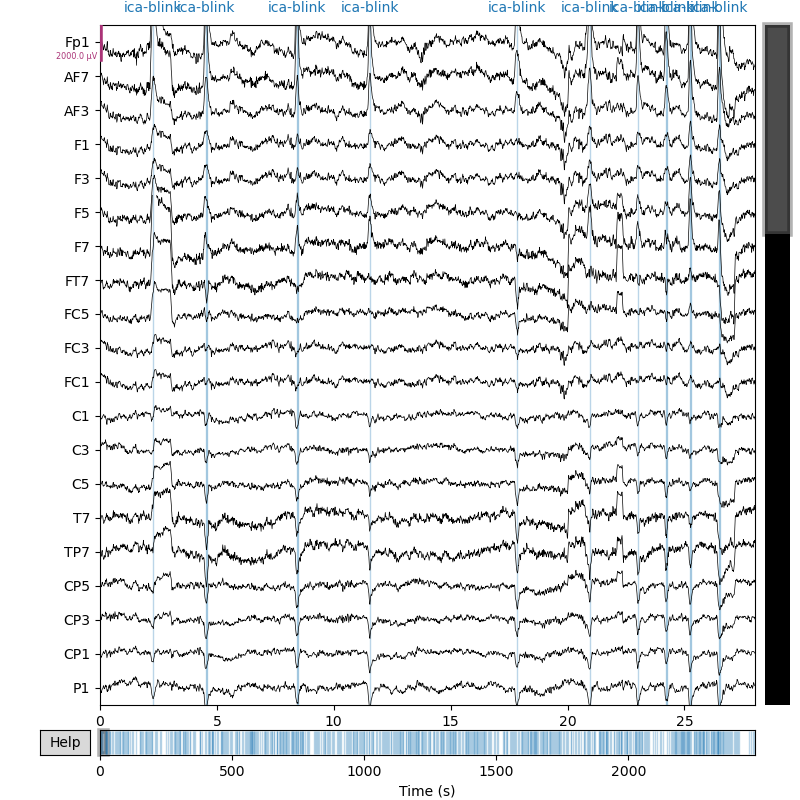

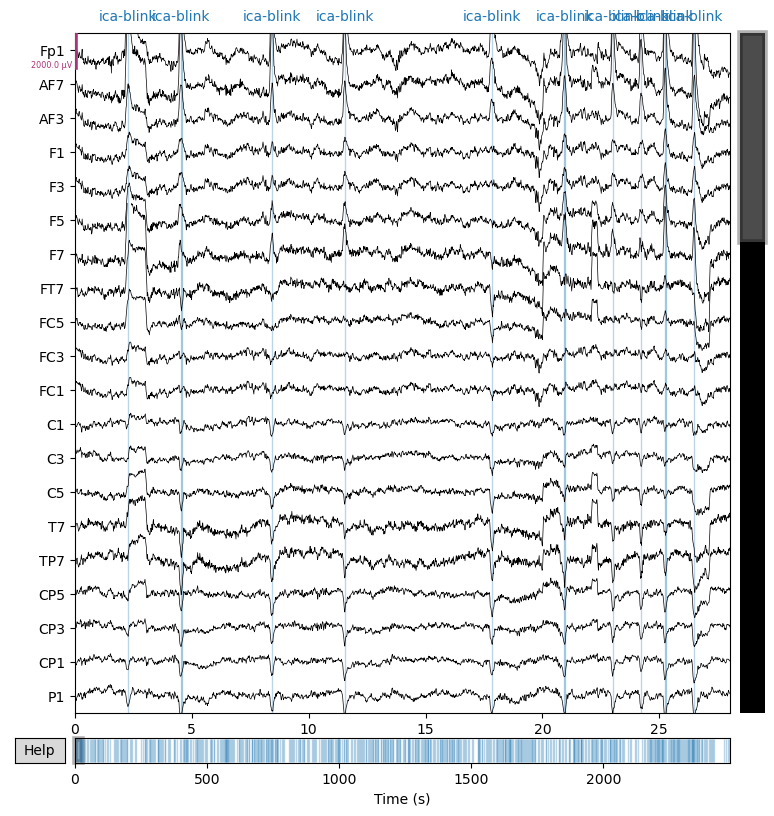

In [44]:
ica_eog_events = mne.preprocessing.ica_find_eog_events(
    raw_filt,
    eog_source = eog_src, #eog_src[0][0],
    event_id = ica_eog_event_id,
    #ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
)

ica_eog_annots = mne.annotations_from_events(
    ica_eog_events,
    sfreq = raw.info['sfreq'],
    event_desc = {ica_eog_event_id: "ica-blink"},
)

raw.set_annotations(ica_eog_annots)

raw.plot(
    duration = 28,
    scalings = {'eeg': 1e-3},
)

Get IC sources for the epochs:

In [45]:
if 0:
    eog_src = ica.get_sources(eps)
    print(eog_src)

    eog_src.get_data().shape
    # trials, sources, times

    print(eog_src.get_data()[:, BLINK_IC_IDX, :].shape)
    eog_src.get_data()[:, BLINK_IC_IDX, :]

    plt.plot(
        eog_src.times, 
        eog_src.get_data()[:, BLINK_IC_IDX, :].T)
    plt.show()

    ica.get_sources(raw_filt).get_data().shape

In [47]:
ica_eog_events

array([[   145,      0,      3],
       [   291,      0,      3],
       [   540,      0,      3],
       ...,
       [157722,      0,      3],
       [158180,      0,      3],
       [158371,      0,      3]])

# Compare EOG event finding between scalp and ICA domains

## EOG events from scalp

orig_trial_pos: [ 3  9 15 16 27 28 30 37 48 49 53  4  7 12 29 34 35 38 52 59 63 71  8 11
 22 24 31 36 39 40 67 75 87 13 18 25 45 46 50 55 56 57 65 77 19 20 32 33
 42 58 62 70 80 85 88  2 26 43 44 47 60 61 68 69 74 86  1 14 17 23 41 64
 72 76 78 79 84  5  6 10 21 51 54 66 73 81 82 83]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

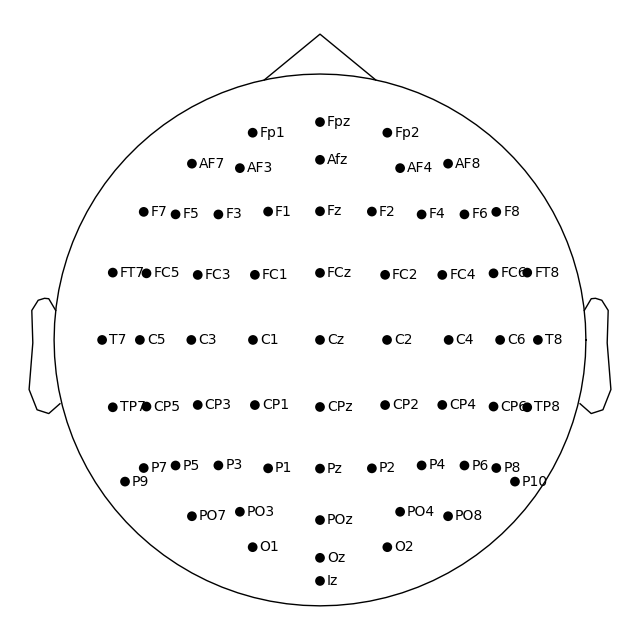

Using EOG channels: Fpz, Fp1, Fp2, AF7, AF3, Afz, AF4, AF8
EOG channel index for this subject is: [ 0  1  2 32 33 34 35 36]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 640 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 535 significant peaks
Number of EOG events detected: 535


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


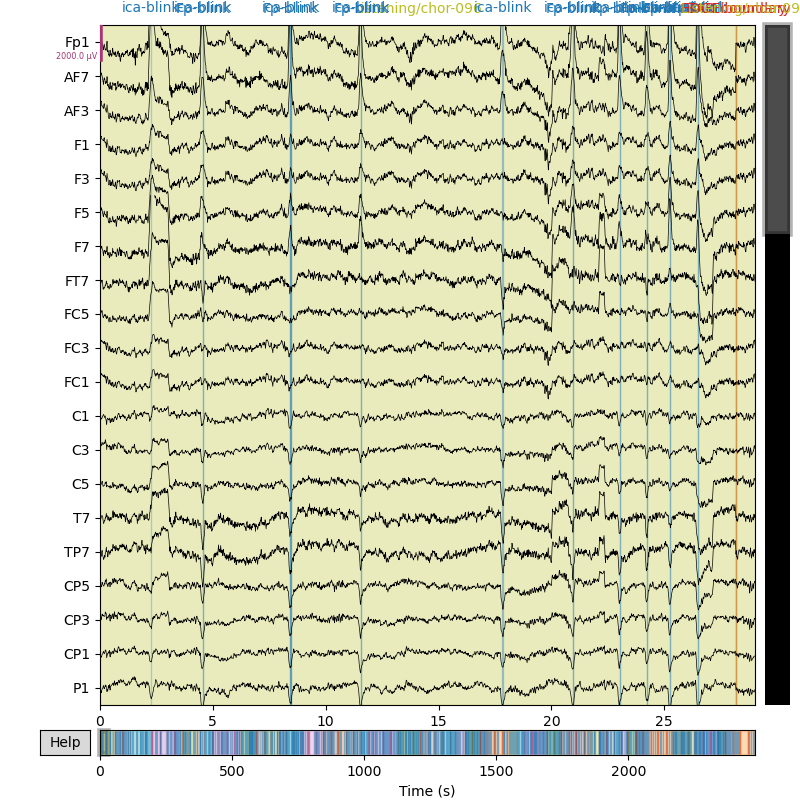

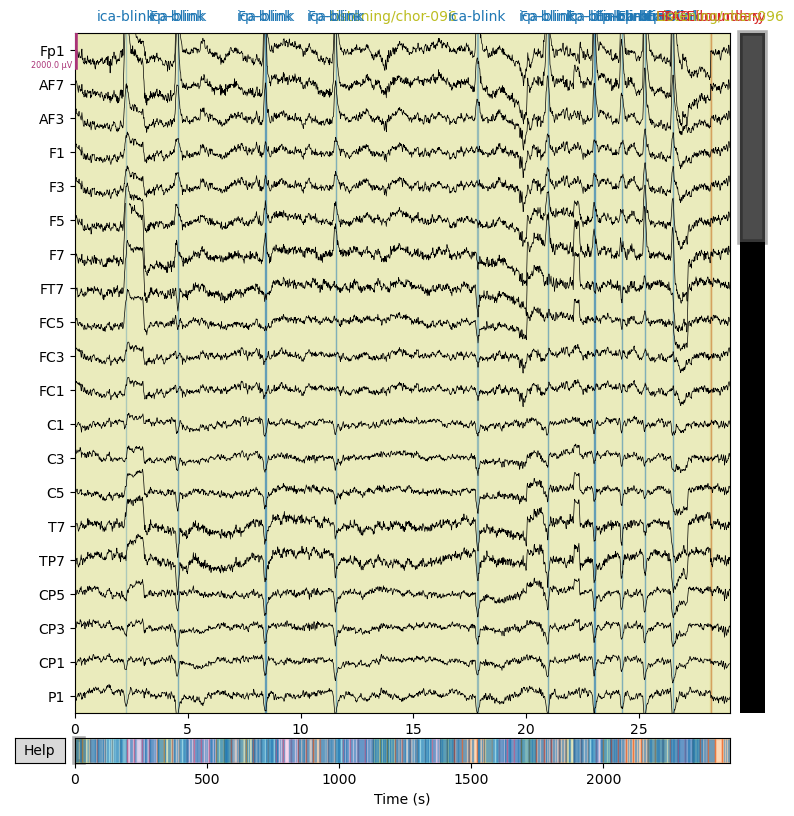

In [54]:
raw = merged_raws_for_subject(subjectID)
print(raw.annotations)

raw.set_eeg_reference('average')
mne.viz.plot_montage(raw.info.get_montage())

eog_event_id = 998 # default mne EOG events
eog_events = mne.preprocessing.find_eog_events(
    raw,
    l_freq = 1, # default
    h_freq = 10, # default
    event_id = eog_event_id,
    thresh = 5e-3, # this would need to be tuned per subject?
    ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
)

eog_annots = mne.annotations_from_events(
    eog_events,
    sfreq = raw.info['sfreq'],
    event_desc = {eog_event_id: "Fp-blink"},
)

trial_annots = raw.annotations.copy()
raw.set_annotations(trial_annots + ica_eog_annots + eog_annots)

#raw.add_events(eog_events)

scalings = {'eeg': 1e-3}
raw.plot(
    duration = 29,
    scalings = scalings
)

# Run ICA for all trials across selected subjects

To Do:

We don't need all this indexing. Just the trial# is sufficient to identify condition and song.

In [69]:
def get_blink_events(subjectIDs, bpf_filter=False, common_average=False):
    eog_peaks = {}

    for subjectID in subjectIDs:
        eog_peaks[subjectID] = {}

        raw = merged_raws_for_subject(subjectID) #merged_raw_trials[subjectID]
        trial_annots = raw.annotations.copy()

        # BPF
        if bpf_filter:
            raw_filt = raw.copy().filter( # ica-label needs 1-100Hz
                l_freq=1, 
                h_freq=30,
                verbose = 'ERROR',
            )
        else:
            raw_filt = raw

        # Reference to average
        if common_average:
            raw_filt.set_eeg_reference(
                'average',
                verbose = 'ERROR',
                )

        # Run ICA
        ica = mne.preprocessing.ICA(
            n_components = 63,
            # method='infomax', # needed by ica-label, but takes longer to run than fastica (default)
            verbose = 'ERROR',
        )

        ica.fit(
            raw_filt,
            reject = None,
            reject_by_annotation=False,
            verbose = 'ERROR',
        )

        # ica.plot_sources(raw_filt)
        
        # find which ICs match the EOG pattern
        eog_indices, eog_scores = ica.find_bads_eog(
            raw_filt,
            # skip filtering again since we are already using 1-10Hz BPF
            l_freq = None, 
            h_freq = None, 
            ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
            verbose = 'ERROR',
        )
        
        # Assume top component is blinks (use the top eog scoring ICA component)
        eog_src = ica.get_sources(raw_filt)[eog_indices[0]]
        '''
        plt.title(f"Top IC for {raw_filt.info['description']}")
        plt.plot(eog_src[1], eog_src[0][0])
        plt.show()
        '''

        # Find EOG events frop top IC
        ica_eog_event_id = 3
        ica_eog_events = mne.preprocessing.ica_find_eog_events(
            raw_filt,
            eog_source = eog_src[0][0],
            event_id = ica_eog_event_id,
            #ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
        )

        eog_peaks[subjectID]['ica_eog_events'] = ica_eog_events[:, 0]
        eog_peaks[subjectID]['source'] = eog_src[0][0]
        eog_peaks[subjectID]['trial_annots'] = trial_annots
    
    return eog_peaks

(This step takes about 3 mins per subject!)
(Can be faster if bpf and common average is applied, but skipping those for now)

In [70]:
LOAD_SAVED_DATA = not True

subjectIDs = range(1, 21+1)
for subjectID in subjectIDs:
    
    if LOAD_SAVED_DATA:
        eog_peaks = np.load(f'eog_peaks_sub{subjectID}_merged_raws.npy', allow_pickle=True)
        eog_peaks = eog_peaks.flat[0]
        
    else: # This step takes 15 mins!
        eog_peaks = get_blink_events([subjectID])
        
        np.save(
            file = f'eog_peaks_sub{subjectID}_merged_raws',
            arr = eog_peaks,
        )

orig_trial_pos: [ 3  9 15 16 27 28 30 37 48 49 53  4  7 12 29 34 35 38 52 59 63 71  8 11
 22 24 31 36 39 40 67 75 87 13 18 25 45 46 50 55 56 57 65 77 19 20 32 33
 42 58 62 70 80 85 88  2 26 43 44 47 60 61 68 69 74 86  1 14 17 23 41 64
 72 76 78 79 84  5  6 10 21 51 54 66 73 81 82 83]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 3 10 17 24 28 34 41 50 51 80 83  5  9 11 18 36 40 55 57 63 66 78 12 20
 30 42 53 54 56 69 71 81 86 15 21 22 23 61 62 64 67 79 87 88  1  7 32 33
 39 45 46 49 59 65 85  4  6 27 29 31 38 47 60 70 74 76  2  8 14 25 35 44
 52 73 77 82 84 13 16 19 26 37 43 48 58 68 72 75]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 8 17 18 30 36 37 49 56 58 64 76  7 26 29 35 39 43 51 73 79 85 86  5 21
 23 34 52 53 60 61 63 77 78 12 33 41 46 50 57 59 70 74 81 84  1  4 10 16
 32 38 45 65 67 71 83  3  9 15 19 28 42 44 55 68 87 88 13 14 20 22 24 40
 47 48 62 72 75  2  6 11 25 27 31 54 66 69 80 82]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 1  7 21 23 25 47 49 53 55 59 85  3  5  9 13 15 29 35 41 73 81 87 11 27
 39 43 57 63 65 69 71 75 83 17 19 31 33 37 45 51 61 67 77 79  2  8 22 24
 26 48 50 54 56 60 86  4  6 10 14 16 30 36 42 74 82 88 12 28 40 44 58 64
 66 70 72 76 84 18 20 32 34 38 46 52 62 68 78 80]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 1 19 20 27 44 45 65 70 73 78 87 17 18 23 30 31 35 37 41 52 72 74  4  5
 10 21 29 42 50 60 62 68 76 26 28 32 33 51 56 57 59 80 81 86  2  3  6  9
 39 46 63 66 69 83 88  7 13 14 22 24 36 47 48 54 71 84 11 12 15 34 38 43
 49 53 64 77 82  8 16 25 40 55 58 61 67 75 79 85]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 1 19 20 27 44 45 65 70 73 78 87 17 18 23 30 31 35 37 41 52 72 74  4  5
 10 21 29 42 50 60 62 68 76 26 28 32 33 51 56 57 59 80 81 86  2  3  6  9
 39 46 63 66 69 83 88  7 13 14 22 24 36 47 48 54 71 84 11 12 15 34 38 43
 49 53 64 77 82  8 16 25 40 55 58 61 67 75 79 85]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [15 23 39 46 58 62 64 72 75 81 87 12 20 25 30 32 34 37 41 63 66 88  4  7
  9 17 18 31 42 47 54 56 67  6  8 19 24 26 35 36 59 79 80 83  2 13 27 38
 44 57 70 77 78 82 84  1 21 49 52 65 68 69 71 76 85 86  5 10 14 28 29 43
 45 50 55 73 74  3 11 16 22 33 40 48 51 53 60 61]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 7 12 31 35 37 44 57 66 76 81 82  4  8 18 22 28 46 51 73 75 85 88 13 17
 24 30 41 42 53 58 68 71 84  5 21 26 29 33 39 60 64 69 77 80 27 32 38 45
 50 52 54 56 72 78 83  2  3  6  9 19 20 25 49 74 79 86 11 15 16 34 36 43
 48 55 61 65 70  1 10 14 23 40 47 59 62 63 67 87]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 640 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 7 significant peaks
Number of EOG events detected: 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [10 17 19 38 40 43 45 64 66 73 81  6 16 20 26 31 34 35 36 67 75 86  5  8
 12 14 15 29 37 41 42 47 85 11 25 27 55 56 58 61 76 80 82 84  3  7 13 48
 52 57 60 63 74 78 83  1  2 18 21 24 33 62 68 69 70 87  4  9 28 30 32 46
 50 53 59 65 79 22 23 39 44 49 51 54 71 72 77 88]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 1 19 20 27 44 45 65 70 73 78 87 17 18 23 30 31 35 37 41 52 72 74  4  5
 10 21 29 42 50 60 62 68 76 26 28 32 33 51 56 57 59 80 81 86  2  3  6  9
 39 46 63 66 69 83 88  7 13 14 22 24 36 47 48 54 71 84 11 12 15 34 38 43
 49 53 64 77 82  8 16 25 40 55 58 61 67 75 79 85]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 2 13 21 31 46 47 53 61 65 84 86  4  8 18 49 54 63 64 66 74 78 80  7 11
 16 19 25 32 41 52 57 58 88 20 24 33 42 43 67 70 71 72 75 77 14 15 22 26
 29 30 38 39 44 73 87  5 10 12 17 27 40 45 48 69 76 79  1  3  9 23 51 55
 56 59 62 82 83  6 28 34 35 36 37 50 60 68 81 85]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 3  9 30 33 39 41 45 59 77 81 85  5  6 25 34 35 37 48 54 65 75 88  7 11
 16 19 22 23 47 66 72 74 84 17 26 36 42 44 50 51 52 64 78 87  1  4 14 21
 29 46 73 79 82 83 86 10 18 27 31 40 55 56 57 58 62 76 13 24 28 32 43 53
 61 63 67 69 70  2  8 12 15 20 38 49 60 68 71 80]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [23 25 26 32 35 39 53 57 58 68 79  6 14 17 33 38 49 71 73 76 80 82  8 22
 28 31 45 46 50 56 74 75 83  2  9 12 19 27 29 43 47 51 61 62  3  7 10 37
 42 44 60 63 69 70 84  4 18 24 30 36 48 52 59 78 81 88 11 16 20 21 40 41
 55 64 66 85 87  1  5 13 15 34 54 65 67 72 77 86]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [16 17 19 27 34 54 56 71 75 78 79  4  5 11 12 24 29 45 62 64 80 87 20 22
 35 66 67 74 76 77 82 85 86  1  3  8  9 14 31 41 43 44 51 69  2 10 21 40
 49 58 61 70 73 83 88 13 23 26 28 38 48 50 55 63 65 84 15 25 30 32 33 37
 46 47 52 60 81  6  7 18 36 39 42 53 57 59 68 72]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 1 17 19 20 33 37 38 44 53 55 77  4  7  9 11 23 40 45 54 66 70 76 13 18
 27 31 35 39 42 57 63 75 87 10 12 16 32 36 43 51 71 78 79 85  2  8 28 49
 52 59 67 68 69 82 88  3 14 22 24 29 46 50 64 80 81 83  5  6 15 21 25 56
 58 61 65 84 86 26 30 34 41 47 48 60 62 72 73 74]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 1  7 14 16 17 20 37 41 55 64 80  5  9 15 21 26 30 42 53 70 78 82  2 22
 32 36 51 58 62 79 81 86 87 10 33 47 52 56 66 69 72 73 75 76  8 13 19 23
 25 34 57 60 68 77 88  3  6 29 35 38 48 50 74 83 84 85 24 28 31 39 43 44
 45 46 49 59 63  4 11 12 18 27 40 54 61 65 67 71]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [16 30 34 40 47 49 71 83 84 86 87  6  8 25 31 36 43 44 56 64 73 76  3  7
 13 21 22 33 35 46 57 66 80  9 17 23 24 38 54 58 61 62 79 81 10 11 14 19
 29 37 41 51 52 77 82  1 18 20 26 39 45 48 55 67 69 85  5 12 15 28 32 42
 50 59 70 74 78  2  4 27 53 60 63 65 68 72 75 88]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 5 30 35 36 37 69 71 77 80 83 87  8 13 15 22 38 47 51 60 75 78 84  4  6
 24 31 32 40 41 53 58 67 68 16 18 21 25 26 28 39 45 48 64 70  2  3  7 14
 33 52 54 61 73 81 85  9 11 23 42 46 55 59 63 65 74 86 12 19 27 29 43 44
 49 50 56 62 82  1 10 17 20 34 57 66 72 76 79 88]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 1  7 14 15 19 22 43 53 57 75 80 13 18 45 47 48 49 51 52 54 71 84  5  8
 20 25 33 35 36 40 42 81 86  6 10 16 31 34 44 60 62 65 70 78  2  9 11 12
 26 30 39 72 76 77 82  3  4 21 27 32 41 50 67 74 83 88 23 37 46 56 58 59
 61 63 66 73 85 17 24 28 29 38 55 64 68 69 79 87]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [20 40 41 42 58 62 66 67 70 73 82  2  3 15 24 25 29 31 52 56 60 64  6  9
 10 27 33 35 39 72 74 87 88 19 23 28 37 43 55 57 71 75 76 80  7 21 22 26
 32 36 46 47 48 49 78  5 11 14 17 50 53 61 63 65 77 83  1  8 13 44 54 59
 68 79 81 84 86  4 12 16 18 30 34 38 45 51 69 85]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


orig_trial_pos: [ 7 16 20 27 41 42 60 71 74 76 85  2 10 11 18 44 50 51 52 53 55 82  1 24
 34 40 46 57 63 70 75 79 81  8 28 32 37 38 43 58 62 69 72 73  4  9 19 30
 31 56 61 68 77 83 86 17 21 23 29 35 36 49 54 67 80 88  3  5 13 15 22 33
 47 48 65 66 84  6 12 14 25 26 39 45 59 64 78 87]
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.156 secs
Ready.
(1803,)
(1803, 64)
Creating RawArray with float64 data, n_channels=65, n_times=1803
    Range : 0 ... 1802 =      0.000 ...    28.1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [66]:
eog_peaks[1]['ica_eog_events'].shape

(611,)

In [57]:
eog_peaks.keys()

odict_keys([1])

Plot top IC (highest EOG score) for all subjects, conditions, songs, and trials

In [ ]:
AVG_SCALE = 10
AVG_OFFSET = 15

for subjectID in eog_peaks:

    # Make a new figure per subject, song, and condition 
    plt.figure(figsize=(16, 16))

    t = np.arange(start=0, stop=1803, step=1, dtype='float64')

    # Container for collecting average across trials
    src_avg = [np.zeros_like(t)]*8
    N_avg = 11 #len(eog_peaks[subjectID])
    
    trialOffset = [0]*8

    # Plot eog_source traces for each subject, trial
    for trialIdx in eog_peaks[subjectID]:

        eog_source = eog_peaks[subjectID][trialIdx]['source']
        max_peak = np.max(eog_source)
        min_peak = np.min(eog_source)
        if np.abs(min_peak) > np.abs(max_peak):
            eog_source /= min_peak # normalize, flip polarity
        else:
            eog_source /= max_peak # normalize

        stimIdx = stimIdxs[trialIdx]
        condIdx = condIdxs[trialIdx]

        pltIdx = 4*(condIdx-1) + stimIdx

        # Plot Fp1 data for these trials
        plt.subplot(4, 2, pltIdx)

        # Plot and add an offset for each trial
        plt.plot(eog_source + trialOffset[pltIdx-1]) # chan0 is FP1

        # Average
        src_avg[pltIdx-1] += eog_source / N_avg

        trialOffset[pltIdx-1] += 1
            
    # Also plot notes/beats and add titles
    for stimIdx in [1, 2, 3, 4]: # ordering of stim doesn't matter for plotIdx
        stimLabel = stimId_to_Song_map[stimIdx]
        notes = t[stim[stimLabel]['notes']]
        beats = t[stim[stimLabel]['beats']>0]

        for condIdx in [1, 2]:
            condLabel = condId_to_State_map[condIdx]

            pltIdx = 4*(condIdx-1) + stimIdx

            # Plot Fp1 data for these trials
            plt.subplot(4, 2, pltIdx)

            # Plot the average
            plt.plot(AVG_SCALE * src_avg[pltIdx-1] + AVG_OFFSET, 
                     label=f'{AVG_SCALE} x avg')

            # draw beat/note onsets
            for note in notes:
                plt.axvline(x=note, c='r', linewidth=1, alpha=0.5, linestyle=':')
            for beat in beats:
                plt.axvline(x=beat, c='r', linewidth=1, alpha=0.9) #0 * t_bar[beats_bar], '*')

            title_str = '' #'='*50 + '\n'
            title_str += f'Subject: {subjectID}\n'
            title_str += f'{condLabel}: {stimLabel}\n'
            title_str += f'Trials: {N_avg}'
            plt.title(title_str)

            plt.xlabel('Time [Samples]')
            plt.ylabel('Trial #')
            plt.legend(loc='upper right', prop={'size': 6}) #, bbox_to_anchor=[1.5, 0.5])
            #print(title_str)

            pltIdx += 1

    plt.tight_layout()

In [ ]:
len(raw_trials[1])

In [ ]:
from scipy import signal

fs = 64
two_pi = 2*np.pi

lo_cutoff_Hz = 1
hi_cutoff_Hz = 8

sos = signal.butter(
    N = 2,
    Wn = [lo_cutoff_Hz, hi_cutoff_Hz],
    btype = 'bandpass',
    analog = False,
    output = 'sos',
    fs = fs,
)

'''
b, a = signal.butter(
    N = 2,
    Wn = [0.1, 30],
    btype = 'bandpass',
    analog = False,
    output = 'ba',
    fs = 64,
)
'''

# Freq response 
# code from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
#ω, h = signal.freqs(b, a)

plt.figure()

ω, h = signal.sosfreqz(sos)
plt.semilogx(ω/two_pi, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [ ]:
# Try different BPF settings to try and improve EOG event detection 

def ica_find_eog_events_custom(raw_trials, subjectID, trialIdx, source, l_freq, h_freq):
    
    #print(f'[{trialIdx}] from {raw_trials[subjectID]}')
    
    raw = raw_trials[subjectID][trialIdx-1]

    # Find EOG events frop top IC
    ica_eog_event_id = 3
    ica_eog_events = mne.preprocessing.ica_find_eog_events(
        raw,
        eog_source = source,
        event_id = ica_eog_event_id,
        l_freq = l_freq,
        h_freq = h_freq,
        verbose='ERROR',
        #ch_name = ['Fpz', 'Fp1', 'Fp2', 'AF7', 'AF3', 'Afz', 'AF4', 'AF8'],
    )

    return ica_eog_events

from scipy.signal import find_peaks

def find_peaks_from_ica_source(
    eog_source,
    fs = 64,
    height = 0.5,
    distance = 32,
    bpf = True,
    l_freq = 1,
    h_freq = 10,
    order = 2,
):
    # Normalize eog source
    max_peak = np.max(eog_source)
    min_peak = np.min(eog_source)
    if np.abs(min_peak) > np.abs(max_peak):
        eog_source /= min_peak # normalize, flip polarity
    else:
        eog_source /= max_peak # normalize

    if bpf:
        sos = signal.butter(
            N = order,
            Wn = [l_freq, h_freq],
            btype = 'bandpass',
            analog = False,
            output = 'sos',
            fs = fs,
        )
        eog_source = signal.sosfiltfilt(sos, eog_source)

    # Find peaks
    ica_eog_events, _ = find_peaks(
        eog_source,
        height = height, 
        distance = distance, # could miss double blinks 
    )

    return ica_eog_events

In [ ]:
CUSTOM_BPF = False
USE_PEAK_FINDER = True
UPDATE_EOG_PEAKS = True

# Plot and add an offset for each trial
t = np.arange(start=0, stop=1803, step=1)

for subjectID in eog_peaks:
    
    plt.figure(figsize=(8, 48))
    pltIdx = 1


    # Path to data for selected subject
    sub1_mat = loadmat(dataDir+f"/dataCND/dataSub{subjectID}.mat", simplify_cells = True) 

    # Randomized trial order for current subject
    orig_trial_pos = sub1_mat['eeg']['origTrialPosition']
    print(f'orig_trial_pos shape: {orig_trial_pos.shape}')

    # Get current subject's song and condition ordering (since its randomized)
    thisSubStimOrder = stimIdxs[(orig_trial_pos-1)] # convert to being zero indexed
    thisSubCondOrder = condIdxs[(orig_trial_pos-1)]
    print(f'Subject{subjectID} stim order: {thisSubStimOrder}')
    print(f'Subject{subjectID} cond order: {thisSubCondOrder}')
    

    for stimIdx in [1, 2, 3, 4]: # top to bottom on the sheet music
        stimLabel = stimId_to_Song_map[stimIdx]

        for condIdx in [1, 2]:
            condLabel = condId_to_State_map[condIdx]

            # Find trials matching this song and condition
            trialsToEpoch = np.where(
                (thisSubStimOrder == stimIdx) & (thisSubCondOrder == condIdx)
            )[0]

            trials_to_plot = trialsToEpoch # idxs[condLabel][stimLabel]

            # Plot Fp1 data for these trials
            plt.subplot(8, 1, pltIdx)
            offset = 0
            N_avg = 11
            source_avg = np.zeros_like(t, dtype='float64')
            
            for trialIdx in trials_to_plot:
                source = eog_peaks[subjectID][trialIdx]['source']

                if CUSTOM_BPF == True:
                    ica_eog_events = ica_find_eog_events_custom(
                        raw_trials, 
                        subjectID, 
                        trialIdx, 
                        source,
                        l_freq = 1,
                        h_freq = 3,
                    )
                elif USE_PEAK_FINDER:
                    ica_eog_events = find_peaks_from_ica_source(
                        source,    
                        height = 0.25,
                        distance = 20, # assuming half_width = 10 below
                        l_freq = 1,
                        h_freq = 8,
                        order = 2,
                    )
                else:
                    ica_eog_events = eog_peaks[subjectID][trialIdx]['ica_eog_events']

                if UPDATE_EOG_PEAKS:
                    eog_peaks[subjectID][trialIdx]['ica_eog_events'] = ica_eog_events

                # print(t)

                # plt.plot(fp1_data_hp + offset -1)
                ic_trace, = plt.plot(
                    t,
                    source + offset,
                    linewidth = 0.5,
                )
                
                plt.plot(
                    t[ica_eog_events], 
                    source[ica_eog_events] + offset, 
                    '*',
                    color = ic_trace.get_color())

                offset += 1 # increment offset for next run

                # Average
                source_avg += source / N_avg

            # Plot the average
            # print(fp1_avg)
            offset = 12
            plt.plot(10 * source_avg + offset, label='scaled avg')

            # Plot the note onsets
            plt.plot(offset * note_onsets, 'r', 
                     label='note', 
                     alpha=0.2,
                     linewidth=1
                    ) # 1 = expectations

            # Plot metronome hits (could overlap with some notes)
            plt.plot(offset * cueExp, 
                     'r', 
                     label='bar', 
                     alpha=0.5,
                     linewidth=1
                    )

            condName = condId_to_State_map[condIdx]
            stimName = stimId_to_Song_map[stimIdx]

            title_str = '' #'='*50 + '\n'
            title_str += f'Subject {subjectID}: top EOG IC across trials\n'
            title_str += f'Task [{condIdx}]: {condName}\n'
            title_str += f'Stim [{stimIdx}]: {stimName}\n'
            title_str += f'Trials: {trials_to_plot}'
            plt.title(title_str)

            plt.xlabel('Time [Samples]')
            plt.ylabel('Trial #')
            plt.legend(loc='upper right', prop={'size': 6}) #, bbox_to_anchor=[1.5, 0.5])
            #print(title_str)

            pltIdx += 1

    plt.tight_layout()

In [ ]:
def blink_atten(
        t, 
        peaks, 
        half_width
    ):
    peaks_sq = np.zeros_like(t)
    for peak in peaks:
        start_ndx = peak-half_width
        stop_ndx = peak+half_width
        if start_ndx < 0:
            start_ndx = 0
        if stop_ndx > len(t):
            stop_ndx = len(t)
        peaks_sq[start_ndx : stop_ndx] += 1
    return peaks_sq

In [ ]:
import numpy as np
np.random.seed(260)

NOTES_Y_OFFSET = 12

half_width = 10

t = np.arange(start=0, stop=len(cueExp), step=1)

peaks_sq_all = {}
for subjectID in eog_peaks:
    peaks_sq_all[subjectID] = {}
    
    for stimIdx in [1, 2, 3, 4]: # top to bottom on the sheet music
        stimLabel = stimId_to_Song_map[stimIdx]
        peaks_sq_all[subjectID][stimLabel] = {}
        
        notes = t[stim[stimLabel]['notes']]
        beats = t[stim[stimLabel]['beats']>0]

        for condIdx in [1, 2]:
            condLabel = condId_to_State_map[condIdx]
            peaks_sq_all[subjectID][stimLabel][condLabel] = {}

            trials_to_plot = idxs[condLabel][stimLabel]
                
            plt.figure(figsize=(8, 4))

            plt.plot(t[notes], 0*t[notes] + NOTES_Y_OFFSET, '.', label='notes')
            plt.plot(t[beats], 0*t[beats] + NOTES_Y_OFFSET, 'o', label='beats')

            trialCnt = 0
            for trialIdx in trials_to_plot:
                peaks = eog_peaks[subjectID][trialIdx]['ica_eog_events']
                peaks_sq = blink_atten(t, peaks, half_width)
                
                peaks_sq_all[subjectID][stimLabel][condLabel][trialIdx] = peaks_sq

                #plt.plot(t, peaks_sq_rot + trialCnt)
                line, = plt.plot(t, peaks_sq/2 + trialCnt)
                plt.plot(t[peaks], 0*t[peaks] + trialCnt + 0.5, 'x', c=line.get_color())
                plt.plot(t[peaks], 0*t[peaks] + trialCnt + 0.5, 'x', c=line.get_color())

                trialCnt += 1

            plt.xlabel('Time [sample]')
            plt.ylabel('Trial #')
            plt.legend(loc='upper right')
            title_str = f'Subject{subjectID} | {condLabel} | {stimLabel}'
            plt.title(title_str)

## Read in images of the score

In [ ]:
import matplotlib.image as mpimg
import matplotlib as mpl 

# from stackexchange
imgs = {}

start_px = 50
for bar in range(8):
    img = mpimg.imread('data/Score.png')
    
    stop_px = start_px + 70
    imgs[bar] = img[start_px:stop_px, 10:-15].copy()
    
    # offset to the next bar
    start_px += 100
    if bar%2 == 1:
        start_px += 100
        
%matplotlib widget 

for bar in range(8):
    plt.figure()
    plt.imshow(imgs[bar])
    plt.show()

In [ ]:
condId_to_State_map

In [ ]:
condLabels = ['Imagery'] #['Listening'] # consider only listening

allTrialsForNullDistro = {} # by subject

for subjectID in eog_peaks:
    allTrialsForNullDistro[subjectID] = [] # this will get blink info for trials now numbered 0-10

    for trialIdx in eog_peaks[subjectID]:
        stimIdx = stimIdxs[trialIdx]
        condIdx = condIdxs[trialIdx]
        stimLabel = stimId_to_Song_map[stimIdx]
        condLabel = condId_to_State_map[condIdx]

        if condLabel in condLabels: # based on what data we want to use
            val_peaks_sq = peaks_sq_all[subjectID][stimLabel][condLabel][trialIdx]
            allTrialsForNullDistro[subjectID].append(val_peaks_sq)

print(len(allTrialsForNullDistro)) # 3 subjects
print(len(allTrialsForNullDistro[subjectID])) # 11 trials * 4 songs

In [ ]:
stimLabel_to_id_map.keys()

In [ ]:
NUM_LOOPS = 10000
NUM_TRIALS = 11
TEST_STIM_LABELS = ['chor-038', 'chor-096', 'chor-101', 'chor-019']
NOTES_Y_OFFSET = 1

PLOT_POINT_CLOUD = False # this takes a lot of memory => slow down

LOAD_DISTRO = not True
SAVE_DISTRO = not LOAD_DISTRO 

fs = 64

baseline = {} # this will be the null distro
test_trial_avg = {}
peaks_sq_baseline_distro = {}

t = np.arange(start=0, stop=len(cueExp), step=1)

plt.figure(figsize = (32, 16))
pltIdx = 0

rowIdx = 1
for subjectID in allTrialsForNullDistro:
    if LOAD_DISTRO:
        peaks_sq_baseline_distro_samples = np.load(
            f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}.npy"
        )
        print(peaks_sq_baseline_distro_samples.shape)

    else:
        peaks_sq_baseline_distro[subjectID] = []

        # Draw NUM_TRIALS from all trials, and loop NUM_LOOPS times
        for n in range(NUM_LOOPS):
            peaks_sq_baseline = np.zeros_like(t, dtype=np.float64)
            
            randTrialIdxs = np.random.random_integers(
                low=0, 
                high=len(allTrialsForNullDistro[subjectID]) -1, 
                size=NUM_TRIALS,
            )

            for randn in randTrialIdxs: # decide which of 44 trials to draw
                #print(randn)
                peaks_sq_baseline += allTrialsForNullDistro[subjectID][randn]

            peaks_sq_baseline /= NUM_TRIALS # this gives us the average of 11 randomly selected trials
            peaks_sq_baseline_distro[subjectID].append(peaks_sq_baseline)

        #peaks_sq_baseline_distro_samples = np.empty_like(t) # this adds an extra row?
        i = 0
        for samples in peaks_sq_baseline_distro[subjectID]:
            if i == 0:
                peaks_sq_baseline_distro_samples = samples
            else:
                peaks_sq_baseline_distro_samples = np.vstack(
                    (peaks_sq_baseline_distro_samples, samples)
                )
            i+=1
        print(peaks_sq_baseline_distro_samples.shape)

        # sort the samples for every time stamp to get the 95% interval
        peaks_sq_baseline_distro_samples.sort(axis=0)

        # Save to memory!
        if SAVE_DISTRO:
            np.save(
                file=f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}",
                arr=peaks_sq_baseline_distro_samples,
            )

    test_trial_avg[subjectID] = {}
    for stimLabel in TEST_STIM_LABELS:
        pltIdx += 1
        ax = plt.subplot(len(allTrialsForNullDistro), 4+1, pltIdx)

        # Plot null distro point cloud
        if PLOT_POINT_CLOUD:
            #for samples in peaks_sq_baseline_distro[subjectID]:
            for row in range(peaks_sq_baseline_distro_samples.shape[0]):
                line, = ax.plot(
                    t/fs, 
                    peaks_sq_baseline_distro_samples[row], 
                    '.', 
                    #label='validation blinks', 
                    c='k',
                    alpha=0.1,
                    markersize=.1,
                    label = 'Max[null]'
                )
        else:
            max_line, = ax.plot(
                t/fs, 
                peaks_sq_baseline_distro_samples[-1, :], 
                '.', 
                #label='validation blinks', 
                c='k',
                alpha=0.1,
                #markersize=.1,
            )


        # Plot null distro CI intervals
        null_distro_95 = peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :]

        null_line, = ax.plot(
            t/fs, 
            null_distro_95, 
            #marker = '_',
            #ls = '', 
            #label='validation blinks', 
            c='c',
            #alpha=0.1,
        )

        ax.fill_between(
            t/fs, 
            peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :], 
            0, 
            color=null_line.get_color(), 
            alpha=.3,
            label = 'Null Distribution'
        )

        test_trial_avg[subjectID][stimLabel] = np.zeros_like(t, dtype=np.float64)

        notes = t[stim[stimLabel]['notes']]
        beats = t[stim[stimLabel]['beats']>0]
        
        for condLabel in condLabels:

            for trialIdx in peaks_sq_all[subjectID][stimLabel][condLabel]:
                val_peaks_sq = peaks_sq_all[subjectID][stimLabel][condLabel][trialIdx]
                test_trial_avg[subjectID][stimLabel] += val_peaks_sq
                
            test_trial_avg[subjectID][stimLabel] /= len(peaks_sq_all[subjectID][stimLabel][condLabel])

            test_distro = test_trial_avg[subjectID][stimLabel]

            avg_line, = ax.plot(
                t/fs, 
                test_distro, 
                #'.', 
                #label=f'Trial avg. for {stimLabel}', 
                c='r',
                #alpha=0.1,
            )

            ax.fill_between(
                t/fs, 
                test_distro, 
                0, 
                color=avg_line.get_color(), 
                alpha=.3,
                label=f'Trial avg. for {stimLabel}', 
            )

            significant_samples = (test_distro - null_distro_95) > 0

            sig_line, = ax.plot(
                t/fs,
                significant_samples,
                color = 'yellow',
                alpha = 0.3,
            )
            ax.fill_between(
                t/fs, 
                significant_samples, 
                0, 
                color=sig_line.get_color(), 
                label = 'Test > 95%ile of null',
                alpha=.3,
            )

            score = 100 * np.sum(significant_samples) / len(significant_samples)

        ax.plot(t[notes]/fs, 0*t[notes] + NOTES_Y_OFFSET, '.', label='notes')
        beat_dots, = ax.plot(t[beats]/fs, 0*t[beats] + NOTES_Y_OFFSET, 'o', label='beats')
        for beat in beats:
            ax.axvline(
                x=t[beat]/fs, 
                ls='-', # solid line
                alpha=0.2, 
                c=beat_dots.get_color()
            )

        #ax_base = ax.twinx()
        #ax_base.plot(t/fs, peaks_sq_baseline, label='baseline') #, c=line.get_color())
        
        title_str = f'Subject{subjectID} | {condLabel} | {stimLabel} vs. Null'
        title_str+= f'\n#Trials Per Avg: {NUM_TRIALS} | #Loops: {NUM_LOOPS}'
        title_str+= '\nTest > Null for {:.2f}% time'.format(score)
        ax.set_title(title_str)

        ax.set_xlabel('Time [s]')
        ax.set_ylim([-.1, 1.1])

        if (pltIdx % 5) == 1: # first column
            ax.legend(loc='upper right', bbox_to_anchor=[-0.1, 1])

        # Plot the significance curves for all songs in the last column
        axLastCol = plt.subplot(
            len(allTrialsForNullDistro), # nrows = no. of subjects
            4+1, # cols = no. of songs + one "bar codes" plot
            5*rowIdx, # select the last column of this row
        )
        sig_line, = axLastCol.plot(
            t/fs,
            significant_samples + int(stimLabel_to_sheet_order_map[stimLabel]),
            #color = 'yellow',
            label = stimLabel,
            #alpha = 0.3,
        )

        if 0: # overlay score images
            bar = 2 * (stimLabel_to_sheet_order_map[stimLabel] -1)
            # https://stackoverflow.com/questions/61169982/set-location-of-image-in-matplotlib
            image_artist = axLastCol.imshow(imgs[bar])

            if bar == 4: # 8 measures
                SCALE = 1803/fs #* 8/12.
            else: # 9 measures
                SCALE = 1803/fs #* 9/12.

            SCALE /= imgs[bar].shape[0]
            image_artist.set_extent(np.array(image_artist.get_extent())/SCALE)
            transform = mpl.transforms.Affine2D().translate(0, stimLabel_to_sheet_order_map[stimLabel])
            image_artist.set_transform(transform + axLastCol.transData)

        #ax_base.legend(loc='upper right', bbox_to_anchor=[1.3, 1])

    axLastCol.set_ylim([5, 0]) # flip axis to go top to bottom in song order of sheet music
    axLastCol.set_yticks(ticks=[1, 2, 3, 4], labels=['chor-038', 'chor-096', 'chor-101', 'chor-019'])
    #axLastCol.legend(loc='upper right')
    axLastCol.set_ylabel('Song #')
    axLastCol.set_xlabel('Time [s]')
    axLastCol.set_title(f'Subject{subjectID} | {condLabel} | Blink Avg > Null')

    pltIdx += 1 # since we already plotted the last column (bar codes)
    rowIdx += 1

plt.tight_layout()
        
plt.savefig(f'subs{len(allTrialsForNullDistro)}_{condLabel}_nullLoops{NUM_LOOPS}.png',
            format='png',
            dpi = 200,
            )

plt.show()



# Odd and Even Splits

In [ ]:
idxs

In [ ]:
NUM_LOOPS = 10000 #10000
NUM_TRIALS = 11
TEST_STIM_LABELS = ['chor-038', 'chor-096', 'chor-101', 'chor-019']
NOTES_Y_OFFSET = 1

PLOT_POINT_CLOUD = False # this takes a lot of memory => slow down

LOAD_DISTRO = not True
SAVE_DISTRO = not LOAD_DISTRO 

fs = 64

cond_trials = range(len(allTrialsForNullDistro[subjectID])) # this should be handled per subject if trials are dropped
split_trials_odd = [i for i in cond_trials if i%2==1]
split_trials_even = [i for i in cond_trials if i%2==0]

baseline = {} # this will be the null distro
test_trial_avg = {}
peaks_sq_baseline_distro = {}

t = np.arange(start=0, stop=len(cueExp), step=1)

plt.figure(figsize = (32, 16))

for split in ['even']: #, 'odd']:
    if split == 'odd':
        split_trials = split_trials_odd
    else:
        split_trials = split_trials_even
    
    pltIdx = 0
    rowIdx = 1

    for subjectID in allTrialsForNullDistro:
        
        if LOAD_DISTRO:
            peaks_sq_baseline_distro_samples = np.load(
                f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}_{split}.npy"
            )
            print(peaks_sq_baseline_distro_samples.shape)

        else:
            peaks_sq_baseline_distro[subjectID] = []

            # Draw NUM_TRIALS from all trials, and loop NUM_LOOPS times
            for n in range(NUM_LOOPS):
                peaks_sq_baseline = np.zeros_like(t, dtype=np.float64)
                
                randTrialIdxs = np.random.choice(
                    split_trials,
                    size=NUM_TRIALS,
                )
                #print(randTrialIdxs)

                for randn in randTrialIdxs: # decide which of 44 trials to draw
                    #print(randn)
                    peaks_sq_baseline += allTrialsForNullDistro[subjectID][randn]

                peaks_sq_baseline /= NUM_TRIALS # this gives us the average of 11 randomly selected trials
                peaks_sq_baseline_distro[subjectID].append(peaks_sq_baseline)

            #peaks_sq_baseline_distro_samples = np.empty_like(t) # this adds an extra row?
            i = 0
            for samples in peaks_sq_baseline_distro[subjectID]:
                if i == 0:
                    peaks_sq_baseline_distro_samples = samples
                else:
                    peaks_sq_baseline_distro_samples = np.vstack(
                        (peaks_sq_baseline_distro_samples, samples)
                    )
                i+=1
            print(peaks_sq_baseline_distro_samples.shape)

            # sort the samples for every time stamp to get the 95% interval
            peaks_sq_baseline_distro_samples.sort(axis=0)

            # Save to memory!
            if SAVE_DISTRO:
                np.save(
                    file=f"peaks_sq_baseline_distro_samples_sub{subjectID}_{','.join(condLabels)}_{NUM_LOOPS}_{split}",
                    arr=peaks_sq_baseline_distro_samples,
                )

        test_trial_avg[subjectID] = {}
        for stimLabel in TEST_STIM_LABELS:
            pltIdx += 1
            ax = plt.subplot(len(allTrialsForNullDistro), 4+1, pltIdx)

            # Plot null distro point cloud
            if PLOT_POINT_CLOUD:
                #for samples in peaks_sq_baseline_distro[subjectID]:
                for row in range(peaks_sq_baseline_distro_samples.shape[0]):
                    line, = ax.plot(
                        t/fs, 
                        peaks_sq_baseline_distro_samples[row], 
                        '.', 
                        #label='validation blinks', 
                        c='k',
                        alpha=0.1,
                        markersize=.1,
                    )
            else:
                max_line, = ax.plot(
                    t/fs, 
                    peaks_sq_baseline_distro_samples[-1, :], 
                    '.', 
                    #label='validation blinks', 
                    c='k',
                    alpha=0.1,
                    #markersize=.1,
                    label = 'Max[null]'
                )

            # Plot null distro CI intervals
            null_distro_95 = peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :]

            null_line, = ax.plot(
                t/fs, 
                null_distro_95, 
                #marker = '_',
                #ls = '', 
                #label='validation blinks', 
                c='c',
                #alpha=0.1,
            )

            ax.fill_between(
                t/fs, 
                peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :], 
                0, 
                color=null_line.get_color(), 
                alpha=.3,
                label = 'Null Distribution'
            )

            test_trial_avg[subjectID][stimLabel] = np.zeros_like(t, dtype=np.float64)

            notes = t[stim[stimLabel]['notes']]
            beats = t[stim[stimLabel]['beats']>0]
            
            for condLabel in condLabels:
                Navg = 0
                for trialIdx in peaks_sq_all[subjectID][stimLabel][condLabel]:
                    if trialIdx in split_trials:
                        Navg += 1
                        val_peaks_sq = peaks_sq_all[subjectID][stimLabel][condLabel][trialIdx]
                        test_trial_avg[subjectID][stimLabel] += val_peaks_sq
                    
                test_trial_avg[subjectID][stimLabel] /= Navg #len(peaks_sq_all[subjectID][stimLabel][condLabel])

                test_distro = test_trial_avg[subjectID][stimLabel]

                avg_line, = ax.plot(
                    t/fs, 
                    test_distro, 
                    #'.', 
                    #label=f'Trial avg. for {stimLabel}', 
                    c='r',
                    #alpha=0.1,
                )

                ax.fill_between(
                    t/fs, 
                    test_distro, 
                    0, 
                    color=avg_line.get_color(), 
                    alpha=.3,
                    label=f'Trial avg. for {stimLabel}', 
                )

                significant_samples = (test_distro - null_distro_95) > 0

                sig_line, = ax.plot(
                    t/fs,
                    significant_samples,
                    color = 'yellow',
                    alpha = 0.3,
                )
                ax.fill_between(
                    t/fs, 
                    significant_samples, 
                    0, 
                    color=sig_line.get_color(), 
                    label = 'Test > 95%ile of null',
                    alpha=.3,
                )

                score = 100 * np.sum(significant_samples) / len(significant_samples)

            ax.plot(t[notes]/fs, 0*t[notes] + NOTES_Y_OFFSET, '.', label='notes')
            beat_dots, = ax.plot(t[beats]/fs, 0*t[beats] + NOTES_Y_OFFSET, 'o', label='beats')
            for beat in beats:
                ax.axvline(
                    x=t[beat]/fs, 
                    ls='-', # solid line
                    alpha=0.2, 
                    c=beat_dots.get_color()
                )

            #ax_base = ax.twinx()
            #ax_base.plot(t/fs, peaks_sq_baseline, label='baseline') #, c=line.get_color())
            
            title_str = f'Subject{subjectID} | {condLabel} | {stimLabel} vs. Null'
            title_str+= f'\n#Trials Per Avg: {NUM_TRIALS} | #Loops: {NUM_LOOPS} | {split}'
            title_str+= '\nTest > Null for {:.2f}% time'.format(score)
            ax.set_title(title_str)

            ax.set_xlabel('Time [s]')
            ax.set_ylim([-.1, 1.1])

            if (pltIdx % 5) == 1: # first column
                ax.legend(loc='upper right', bbox_to_anchor=[-0.1, 1])

            # Plot the significance curves for all songs in the last column
            axLastCol = plt.subplot(
                len(allTrialsForNullDistro), # nrows = no. of subjects
                4+1, # cols = no. of songs + one "bar codes" plot
                5*rowIdx, # select the last column of this row
            )
            sig_line, = axLastCol.plot(
                t/fs,
                significant_samples + int(stimLabel_to_sheet_order_map[stimLabel]),
                #color = 'yellow',
                label = stimLabel,
                #alpha = 0.3,
            )

            if 0: # overlay score images
                bar = 2 * (stimLabel_to_sheet_order_map[stimLabel] -1)
                # https://stackoverflow.com/questions/61169982/set-location-of-image-in-matplotlib
                image_artist = axLastCol.imshow(imgs[bar])

                if bar == 4: # 8 measures
                    SCALE = 1803/fs #* 8/12.
                else: # 9 measures
                    SCALE = 1803/fs #* 9/12.

                SCALE /= imgs[bar].shape[0]
                image_artist.set_extent(np.array(image_artist.get_extent())/SCALE)
                transform = mpl.transforms.Affine2D().translate(0, stimLabel_to_sheet_order_map[stimLabel])
                image_artist.set_transform(transform + axLastCol.transData)

            #ax_base.legend(loc='upper right', bbox_to_anchor=[1.3, 1])

        axLastCol.set_ylim([5, 0]) # flip axis to go top to bottom in song order of sheet music
        axLastCol.set_yticks(ticks=[1, 2, 3, 4], labels=['chor-038', 'chor-096', 'chor-101', 'chor-019'])
        #axLastCol.legend(loc='upper right')
        axLastCol.set_ylabel('Song #')
        axLastCol.set_xlabel('Time [s]')
        axLastCol.set_title(f'Subject{subjectID} | {condLabel} | Blink Avg > Null')

        pltIdx += 1 # since we already plotted the last column (bar codes)
        rowIdx += 1

    plt.tight_layout()
            
    plt.savefig(f'subs{len(allTrialsForNullDistro)}_{condLabel}_nullLoops{NUM_LOOPS}_{split}.png',
                format='png',
                dpi = 200,
                )

plt.show()



In [ ]:
null_distro_95 = peaks_sq_baseline_distro_samples[int(.95*NUM_LOOPS), :]
test_distro = test_trial_avg[subjectID][stimLabel]

plt.figure(figsize = (9,4))
plt.plot(null_distro_95)
plt.plot(test_distro, ':')
plt.plot((test_distro - null_distro_95) > 0)
plt.show()

In [ ]:
test_trial_avg[subjectID][stimLabel]